<a href="https://colab.research.google.com/github/andrebelem/ASTOC/blob/main/SNIPPET_4_Principal_Component_Analysis_(Nossa_primeira_ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Principal Component Analysis

Este é um notebook para produzir uma PCA usando o scikit-learn (https://scikit-learn.org/stable/auto_examples/index.html#tutorial-exercises)<br>

**RECOMENDO** criar uma rotina de sempre olhar a página principal do scikit


In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Exemplo, extrai os dados para a boia ID 510 - RS5

import pandas as pd
import urllib
import json
from datetime import datetime
time1 = datetime(2023,1,1).timestamp()
time2 = datetime(2023,12,31).timestamp()

print(f'Recuperando dados nos tempos:\n'\
      f'time2 = {datetime.fromtimestamp(time1).strftime("%Y-%m-%d %H:%M:%S")}\n'\
      f'time1 = {datetime.fromtimestamp(time2).strftime("%Y-%m-%d %H:%M:%S")}')

url = f'https://simcosta.furg.br/api/intrans_data?boiaID=510&type=json&time1={int(time1)}&time2={int(time2)}&params=Avg_Sal,Avg_W_Tmp1,Avg_W_Tmp2,Avg_CDOM,Avg_Chl,Avg_DO,C_Avg_Dir_N'

# chamando os dados da boia pela api
df = pd.json_normalize(json.loads(urllib.request.urlopen(url).read()))
# e construindo o array de tempo datetime

# note que pode ser feito diretamente das colunas de tempo ou do timestamp
#df['timestamp'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']])
df = df.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.columns = ['timestamp','Salinidade','DO','Temp1','Temp2','DirN','Chl','CDOM']
df.head(5)

Recuperando dados nos tempos:
time2 = 2023-01-01 00:00:00
time1 = 2023-12-31 00:00:00


,timestamp,Salinidade,DO,Temp1,Temp2,DirN,Chl,CDOM
0,2023-01-01 00:21:40+00:00,33.51,4.24,24.79,24.75,160.34,0.42,2.20
1,2023-01-01 00:51:40+00:00,33.53,4.19,24.71,24.67,133.03,0.38,2.25
2,2023-01-01 02:51:40+00:00,33.55,4.08,24.32,24.29,228.51,0.34,2.19
3,2023-01-01 03:21:40+00:00,33.55,4.13,24.19,24.16,191.37,0.35,2.12
4,2023-01-01 03:51:40+00:00,33.55,4.18,24.09,24.06,184.78,0.36,2.26


In [3]:
# para garantir, salva em parquet
df.to_parquet('SiMCosta-RS5.parquet')

Agora eu tenho um arquivo de dados e **não estou preocupado com o tempo** (ou seja, com a série temporal). Mas veja que isso tem um pequeno problema (!) Vamos discutir isso

## Parte 1 - Garanta que você tem todos os dados

Basicamente estamos lendo os dados aqui e verificando se está tudo certo para a PCA

In [4]:
# Vou separar minha série em dados que vou usar
series = df['timestamp']
mydata = df[['Salinidade','DO','Temp1','Temp2','DirN','Chl','CDOM']]

In [5]:
mydata.head() # veja o que sobrou

,Salinidade,DO,Temp1,Temp2,DirN,Chl,CDOM
0,33.51,4.24,24.79,24.75,160.34,0.42,2.20
1,33.53,4.19,24.71,24.67,133.03,0.38,2.25
2,33.55,4.08,24.32,24.29,228.51,0.34,2.19
3,33.55,4.13,24.19,24.16,191.37,0.35,2.12
4,33.55,4.18,24.09,24.06,184.78,0.36,2.26


In [6]:
# se por acaso sua série tiver algum NaN, **desapareça com ele**
import numpy as np
mydata= mydata.replace(np.nan, 0) # mas o ideal seria você dar um "drop" na linha
#mydata.dropna(inplace=True)
mydata.head()

,Salinidade,DO,Temp1,Temp2,DirN,Chl,CDOM
0,33.51,4.24,24.79,24.75,160.34,0.42,2.20
1,33.53,4.19,24.71,24.67,133.03,0.38,2.25
2,33.55,4.08,24.32,24.29,228.51,0.34,2.19
3,33.55,4.13,24.19,24.16,191.37,0.35,2.12
4,33.55,4.18,24.09,24.06,184.78,0.36,2.26


## MUITO IMPORTANTE ##

A Análise de Componentes Principais é uma análise de exploração de dados e não um "plug-and-play" que responde todas as suas dúvidas de vida. É importante você prestar a atenção a partir daqui para ver que você deve ir para frente e para trás, formando suas hipóteses conforme você explora os dados. **Fique atento**.

In [7]:
# Para realizar a PCA apenas com essas colunas ...
# Note que a PCA é um processo de "escolhas", e por isso, você deve executá-la várias vezes

# mydata2 = mydata[['Salinidade','DO','Temp1','Temp2','DirN','Chl','CDOM']]
mydata2 = mydata[['Salinidade','DO','Temp1','DirN','Chl','CDOM']]
print(mydata2)

       Salinidade    DO  Temp1     DirN   Chl  CDOM
0           33.51  4.24  24.79  160.340  0.42  2.20
1           33.53  4.19  24.71  133.030  0.38  2.25
2           33.55  4.08  24.32  228.510  0.34  2.19
3           33.55  4.13  24.19  191.370  0.35  2.12
4           33.55  4.18  24.09  184.780  0.36  2.26
...           ...   ...    ...      ...   ...   ...
15733        0.00  0.00   0.00  125.551  1.23  8.54
15734        0.00  0.00   0.00  128.391  1.25  8.04
15735        0.00  0.00   0.00  131.671  1.20  8.02
15736        0.00  0.00   0.00  129.271  1.24  8.27
15737        0.00  0.00   0.00    0.000  1.31  8.23

[15738 rows x 6 columns]


In [8]:
# ainda posso fazer a correlação usando outros métodos. Veja aqui https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
mydata2.iloc[:,:].corr(method='pearson')

# Papa-mosca
#df.iloc[:,:].corr(method='pearson') # note que não tem drop no df !

,Salinidade,DO,Temp1,DirN,Chl,CDOM
Salinidade,1.000000,0.146154,0.853314,0.061987,0.143383,0.083646
DO,0.146154,1.000000,0.168663,-0.134014,0.055488,0.051378
Temp1,0.853314,0.168663,1.000000,0.120528,0.093710,-0.037874
DirN,0.061987,-0.134014,0.120528,1.000000,-0.002222,-0.082934
Chl,0.143383,0.055488,0.093710,-0.002222,1.000000,0.517648
CDOM,0.083646,0.051378,-0.037874,-0.082934,0.517648,1.000000


# Parte 2 - Agora é PCA pura !

PCA é uma técnica de redução de dimensão que pega um conjunto de variáveis possivelmente correlacionadas e se transforma em componentes principais linearmente não correlacionados. É usado para enfatizar variações e destacar padrões fortes em um conjunto de dados. <br>

Em palavras simples, a **análise de componentes principais** é um método de extrair variáveis importantes de um grande conjunto de variáveis disponíveis em um conjunto de dados. Ele extrai um conjunto de características de baixa dimensão de um conjunto de dados de alta dimensão com o objetivo de capturar o máximo de informações possível.<br>
<figure>
<figcaption align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg" width="200"><br> Exemplo de uma distribuição de dados na PCA</figcaption>
</figure>

Esta parte do notebook tem como objetivo visualizar os principais componentes usando Python. Você pode encontrar explicações matemáticas nos links fornecidos ao longo do texto. Acima desta parte seus dados já estão na memória e prontos para usar

Vamos começar!

In [9]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(mydata) # <<<<------ Mude aqui e abaixo para mydata2 se quiser modificar o set de dados
x = pd.DataFrame(x, columns=mydata.columns) # aqui criou o dataset X já padronizado e com os mesmos nomes de mydata
x.head()

,Salinidade,DO,Temp1,Temp2,DirN,Chl,CDOM
0,0.820510,0.165655,0.981910,1.190443,0.031257,-0.838706,-0.432087
1,0.822339,0.143536,0.970745,1.170481,-0.236678,-0.903497,-0.413316
2,0.824168,0.094875,0.916313,1.075660,0.700063,-0.968287,-0.435842
3,0.824168,0.116994,0.898169,1.043221,0.335688,-0.952089,-0.462121
4,0.824168,0.139112,0.884212,1.018268,0.271034,-0.935892,-0.409562


In [10]:
from sklearn.decomposition import PCA
import numpy as np
pcamodel = PCA(n_components=5) # <---- FORÇANDO A BARRA !!!
pca = pcamodel.fit_transform(x)
pca.shape # note que ele vai te mostrar o número de linhas e de componentes

(15738, 5)

## Obtendo as componentes da PCA
O cálculo do PCA envolve as seguintes etapas:

* Calcular a [matriz de covariância](https://pt.wikipedia.org/wiki/Matriz_de_covari%C3%A2ncia)
* Calcular os [autovalores e autovetores](https://pt.wikipedia.org/wiki/Autovalores_e_autovetores)
* Formar as Componentes Principais
* Projetar para o novo espaço de componentes

Aqui vamos focar na visualização e interpretação das componentes da PCA e, felizmente, o sklearn fornece o módulo PCA para obter os componentes da PCA. Porém, para aprender mais, siga os links acima.

Em PCA(), `n_components` especifica quantos componentes são retornados após o ajuste e a transformação. O número máximo de componentes depende do número de variáveis. Porém nosso cérebro tem mais facilidade de entender até 3 componentes (afinal, somos seres inteligentes mas ainda no espaço tridimensional).

In [11]:
# esse número é mágico e não faço ideia do que significa
pcamodel.explained_variance_

array([2.15109066, 1.70591633, 1.43445993, 0.90493645, 0.47494659])

## Gráficos de atributos do modelo da PCA
Os componentes do PCA e sua importância podem ser explicados usando os seguintes atributos:
* A **variação explicada** é a quantidade de variação explicada por cada um dos componentes selecionados. Este atributo está associado ao modelo sklearn PCA, conforme `explained_variance_`
* A **razão de variância explicada** é a porcentagem da variância explicada por cada um dos componentes selecionados. Seu atributo é `explained_variance_ratio_`

`pcamodel.explained_variance_` é um atributo da PCA (Análise de Componentes Principais) do scikit-learn que contém a variância explicada de cada componente principal. Cada valor neste array representa a quantidade de **variância dos dados originais** (ou seja, não normalizado) que é explicada por cada componente principal. Esses valores são ordenados em ordem decrescente, ou seja, o primeiro valor corresponde à variância explicada pelo primeiro componente principal, o segundo valor corresponde à variância explicada pelo segundo componente principal e assim por diante. Este atributo é útil para entender quanto cada componente contribui para a explicação da variação total dos dados.

In [12]:
# ****** esta é a parte mais importante *******
# ela diz quanto cada componente explica de variância em seu sistema.
pcamodel.explained_variance_ratio_

array([0.30727914, 0.24368685, 0.20490983, 0.12926842, 0.0678452 ])

In [13]:
# posso agora melhorar esse print
myper = pcamodel.explained_variance_ratio_
print(f'variancia total explicada:{sum(pcamodel.explained_variance_ratio_)}')

variancia total explicada:0.9529894399576885


Esse valor acima: é bom ou ruim ? o que você acha ? Muitos números ! Dificil de guardar o que significam, mas nada que vocês não possam estudar mais. Porém, para ficar mais interessante vamos plotar isso.

In [14]:
import plotly.graph_objects as go

# Criando os dados para o gráfico de barras
barras = go.Bar(
    x=list(range(1, len(pcamodel.explained_variance_) + 1)),
    y=pcamodel.explained_variance_,
    name='Variância Explicada'
)

# Criando os dados para a linha de variância explicada acumulada
linha = go.Scatter(
    x=list(range(1, len(pcamodel.explained_variance_) + 1)),
    y=np.cumsum(pcamodel.explained_variance_),
    mode='lines',
    name='Variância explicada acumulada',
    line=dict(color='red')
)

# Criando a figura
fig = go.Figure(data=[barras, linha])

# Atualizando o layout
fig.update_layout(
    xaxis_title='Componentes',
    yaxis_title='Variância Explicada',
    title='Variância explicada pelos componentes principais e acumulada'
)

# Exibindo o gráfico
fig.show()


In [15]:
import plotly.graph_objects as go

# Criando a lista de números inteiros para o eixo x
x_values = list(range(1, len(pcamodel.explained_variance_ratio_) + 1))

# Criando a figura
fig = go.Figure()

# Adicionando a linha para a variância explicada acumulada
fig.add_trace(go.Scatter(
    x=x_values,
    y=np.cumsum(pcamodel.explained_variance_ratio_),
    mode='lines',
    name='Variância Acumulada explicada',
    marker=dict(color='blue')
))

# Atualizando o layout
fig.update_layout(
    xaxis_title='Numero de componentes',
    yaxis_title='Variância Acumulada explicada',
    title='Variância acumulada explicada pelos componentes principais'
)

# Configurando os ticks do eixo x para mostrar apenas números inteiros
fig.update_xaxes(tickvals=x_values, ticktext=[str(int(x)) for x in x_values])

# Exibindo o gráfico
fig.show()



Você vai ver nos gráficos que a PC-1 explica a maior parte da variação do que os componentes subsequentes. Em outras palavras, a maioria dos recursos são explicados e abrangidos pelo PC-1. Ela que determina quem se alinha com quem (ou quem está mais correlacionado com quem).<br>
## Gráfico de dispersão de PCA1 e PCA2
`pca` contém todos os componentes do PCA. Os dois primeiros deles podem ser visualizados usando o gráfico de dispersão simples. Você pode mudar para a componente que quiser. Isso ajuda a entender a dispersão dos dados.<br>
(nota para os monitores: vamos depois implementar a vizualização 3D aqui https://plotly.com/python/3d-scatter-plots/)

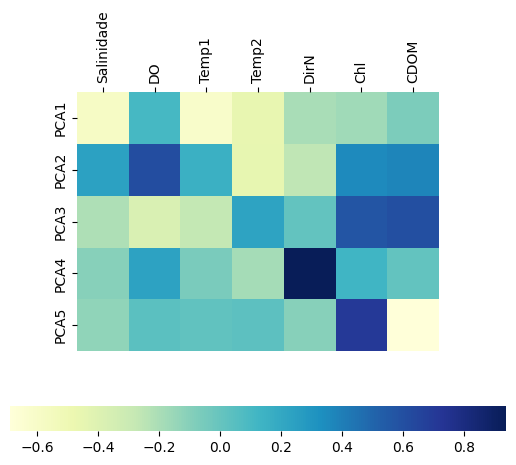

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(x.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.xaxis.set_ticks_position('top') # coloca os xlabels no topo
ax.set_aspect("equal")
plt.xticks(rotation=90) # escreve os xticks na vertical
plt.show()

## Efeito das variáveis em cada componente
O atributo `components_` fornece eixos principais no espaço da PCA, representando as direções de variação máxima nos dados. Isso significa que podemos ver a influência em cada um dos componentes na variância total. Note que os dados foram padronizados, então essa influência é um pouco diferente do que a que vimos lá em cima.

In [19]:
pcamodel.components_.max()

0.9383433843069027

## PCA Biplot
Biplot é um tipo de análise interessante e contém muitas informações úteis.

Ele contém dois gráficos:

* Gráfico de dispersão da PCA que mostra os dois primeiros componentes (já traçamos isso acima)
* Gráfico de carregamento (loadings) da PCA que mostra o quão fortemente cada característica influencia um componente principal.

**PCA Loading Plot**: Todos os vetores começam na origem e seus valores projetados nos componentes explicam quanto peso eles têm naquele componente. Além disso, os ângulos entre os vetores individuais informam sobre a correlação entre eles.

Aprenda mais sobre o biplot [aqui](http://www.nonlinear.com/support/progenesis/comet/faq/v2.0/pca.aspx)

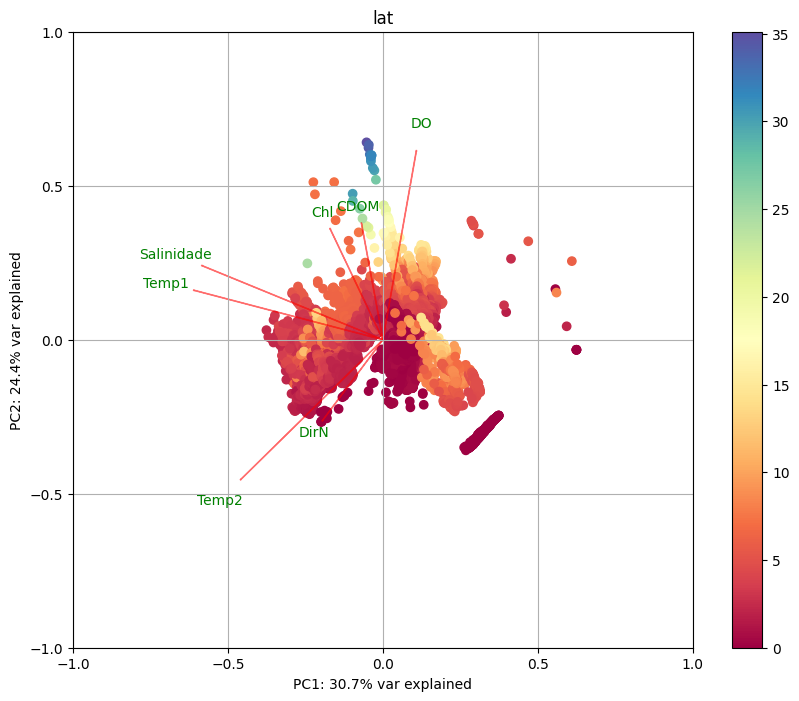

In [20]:
def myplot(score,coeff,labels=None):
    fig, ax = plt.subplots(figsize=(10, 8))

    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    #plt.scatter(xs * scalex,ys * scaley,s=50) # comente aqui para plotar " por exemplo", Chl como resposta
    plt.scatter(xs * scalex,ys * scaley, c= mydata['CDOM'],cmap='Spectral')
    plt.colorbar()
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

    ax.set_xlim([-1,1])
    ax.set_xticks(np.arange(-1,1.5,0.5))
    ax.set_ylim([-1,1])
    ax.set_yticks(np.arange(-1,1.5,0.5))
    ax.set_xlabel(f'PC1: {myper[0]*100:.1f}% var explained')
    ax.set_ylabel(f'PC2: {myper[1]*100:.1f}% var explained')

    plt.title("lat")
    plt.grid()

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(x.columns))
plt.show()

In [21]:
# "loucuras" para posicionar o label
# isso porque não existe uma receita de bolo para plotar um Biplot (ainda)
def pos_check(pos):
    if pos == 'c':
        return('center')
    elif pos == 'l':
        return('left')
    elif pos == 'r':
        return('right')
    elif pos == 't':
        return('top')
    elif pos == 'b':
        return('bottom')
# aqui que plota o gráfico
def plota_PCA(score,coeff,target,labels,myh1,myv1,myh2,myv2,letters):
    'esta subrotina plota a PCA para um alvo específico'
    'labels são os labels das variáveis da PCA'
    'myh1 e myh2 são as posições horizontais para o label no biplot'
    'myv1 e myv2 são as posições verticaos para o label no biplot'
    'letters são as letras do painel da esquerda e direita'
     # faz a leitura do zero aqui

    #### a partir daqui começa o plot
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
    plt.rcParams['font.size'] = '14'

    # primeiro, PC1 x PC2
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # plot
    color_map = plt.get_cmap('Spectral').reversed()
    # plota o primeiro gráfico. Note que pode ser [['Salinidade','DO','Temp1','Temp2','DirN','Chl','CDOM']]
    #im1 = ax1.scatter(xs * scalex,ys * scaley,s=50,c=mydata['Temp1'],cmap=color_map) #voce póde controlar o min e max com vmin e vmax
    #im1 = ax1.scatter(xs * scalex,ys * scaley,s=50,c=mydata['Salinidade'],cmap=color_map)
    im1 = ax1.scatter(xs * scalex,ys * scaley,s=50,c=mydata['CDOM'],cmap=color_map)

    # coloca as variáveis do biplot
    for i in range(n):
        if labels[i]=='RMSE': # deixa o que você quiser em vermelho
            myc = 'r'
        else:
            myc = 'k'
        ax1.arrow(0, 0, coeff[i,0], coeff[i,1],color = myc, ec = myc, fc = myc, alpha = 0.7, lw = 2, head_width = 0.025)
        ax1.text(coeff[i,0]* 1.10, coeff[i,1] * 1.10, labels[i], fontsize = 12, color = myc, ha = pos_check(myh1[i]), va = pos_check(myv1[i]))
    # coloca o texto do lado de fora e o N
    ax1.text(-1.2, 0.8, letters[0], fontsize = 32, color = 'k', ha = 'center', va = 'center')
    ax1.text(-0.7, 0.8, 'N:'+str(len(score)), fontsize = 16, color = 'k', ha = 'center', va = 'center')
    # configura o gráfico A
    ax1.set_xlim([-1,1])
    ax1.set_xticks(np.arange(-1,1.5,0.5))
    ax1.set_ylim([-1,1])
    ax1.set_yticks(np.arange(-1,1.5,0.5))
    ax1.set_xlabel(f'PC1: {myper[0]*100:.1f}% var explained')
    ax1.set_ylabel(f'PC2: {myper[1]*100:.1f}% var explained')
    ax1.grid(ls='--')

    # agora, PC2 x PC3
    xs = score[:,1]
    ys = score[:,2]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # plota o primeiro gráfico. Note que pode ser [['Salinidade','DO','Temp1','Temp2','DirN','Chl','CDOM']]
    #im2 = ax2.scatter(xs * scalex,ys * scaley,s=50,c=mydata['Temp1'],cmap=color_map) #voce póde controlar o min e max com vmin e vmax
    #im2 = ax2.scatter(xs * scalex,ys * scaley,s=50,c=mydata['Salinidade'],cmap=color_map)
    im2 = ax2.scatter(xs * scalex,ys * scaley,s=50,c=mydata['CDOM'],cmap=color_map)
    for i in range(n):
        #print(f'fazendo {i}...{coeff[i,1]}:{coeff[i,2]}...')
        if labels[i]=='RMSE': # deixa o que você quiser em vermelho
            myc = 'r'
        else:
            myc = 'k'
        # coloca as variáveis no biplot
        ax2.arrow(0, 0, coeff[i,1], coeff[i,2],color = myc, ec = myc, fc = myc, alpha = 0.7, lw = 2, head_width = 0.025)
        ax2.text(coeff[i,1]* 1.10, coeff[i,2] * 1.10, labels[i], fontsize = 12, color = myc, ha = pos_check(myh2[i]), va = pos_check(myv2[i]))
    # termina de configurar o gráfico
    ax2.text(-1.2, 0.8, letters[1], fontsize = 32, color = 'k', ha = 'center', va = 'center')
    ax2.set_xlim([-1,1])
    ax2.set_xticks(np.arange(-1,1.5,0.5))
    ax2.set_ylim([-1,1])
    ax2.set_yticks(np.arange(-1,1.5,0.5))
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.set_xlabel(f'PC2: {myper[1]*100:.1f}% var explained')
    ax2.set_ylabel(f'PC3: {myper[2]*100:.1f}% var explained')
    ax2.grid(ls='--')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    mybar = fig.colorbar(im1,cax=cbar_ax)
    #mybar.set_ticks(np.arange(cut,1.2,0.2)) # modifique se necessário
    #mybar.set_label('Temperatura $^oC$')
    #mybar.set_label('Salinidade')
    mybar.set_label('CDOM')

    fig.suptitle('Primeira tentativa de PCA',fontsize=28)
    #plt.savefig('Fig_pca.jpg', format='jpg',dpi=300)
    plt.show()

    return

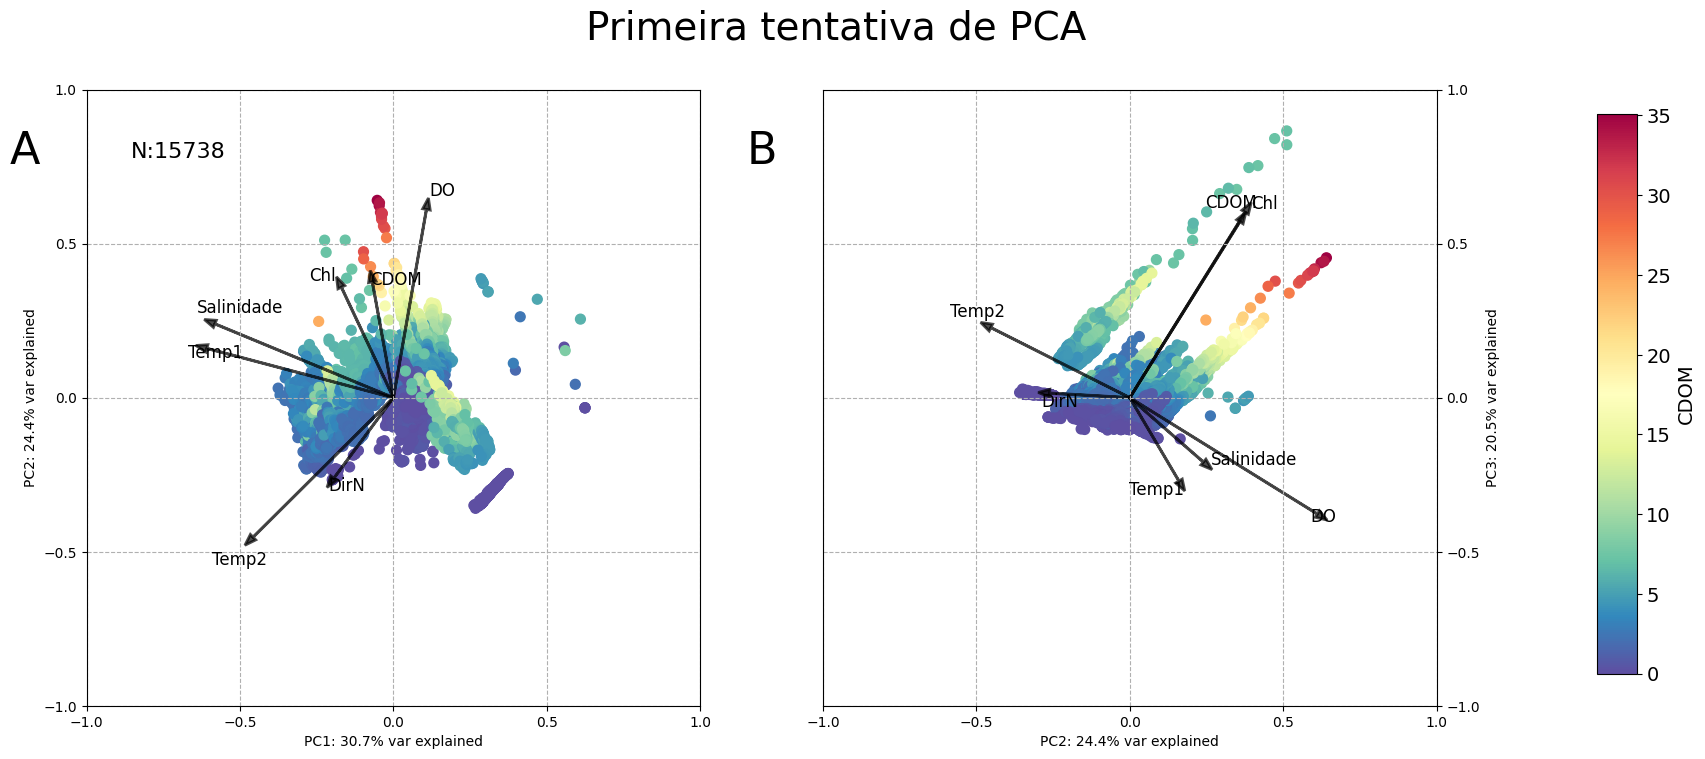

In [22]:
# aqui começa o show

# você pode controlar o label das variáveis como quiser aqui
labels = ['Salinidade','DO','Temp1','Temp2','DirN','Chl','CDOM']

#myh1 = 'llclrl'; myv1 = 'cbtcct'; myh2 = 'rrcllr'; myv2 = 'bcbtct'
myh1 = 'lllclrl'; myv1 = 'bcttcct'; myh2 = 'lrrcllr'; myv2 = 'bbcbtct' # labels com latitude

plota_PCA(pca[:,:],np.transpose(pcamodel.components_[:, :]),'Meu lindo título',labels,myh1,myv1,myh2,myv2,'AB')

Agora que você ENTENDEU o que acontece com as variáveis, LIMPE a sua matriz mydata2 e jogue na análise APENAS aquilo que é ortogonal. Faça este exercício sozinho.

## Leituras interessantes sobre o PCA:
* http://setosa.io/ev/principal-component-analysis/
* https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
* https://blog.bioturing.com/2018/06/18/how-to-read-pca-biplots-and-scree-plots/
* https://en.wikipedia.org/wiki/Principal_component_analysis
* https://medium.com/@aptrishu/understanding-principle-component-analysis-e32be0253ef0